# Notebook to visualize the results from LevSeq campaigns

Here we use the combined output from the campaigns and then visualize as heatmaps for various filters.

# Lineage analysis

In [50]:
! pip install Levenshtein

In [56]:
import pandas as pd
import numpy as np
import Levenshtein
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
from sciutil import SciUtil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import AlignIO
import numpy as np
import re

u = SciUtil()

# Helper functions
# Sort rows by similarity (Hamming distance) to first row
def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum(a != b for a, b in zip(seq1, seq2))
    
def get_hamming(df, parent_name, variant_name):
    parent = df[df['name'] == parent_name]['AA'].values[0]
    variant = df[df['name'] == variant_name]['AA'].values[0]
    # Since the same we can do hamming distance
    hamming_dist = 0
    variant_changes = []
    for i in range(0, len(parent)):
        if parent[i] != variant[i]:
            variant_changes.append(f'{parent[i]}{i+1}{variant[i]}')
            hamming_dist += 1
    u.dp([f'Hamming distance between {parent_name} and {variant_name}', hamming_dist, '_'.join(variant_changes)])
    return variant_changes

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    plt.xticks(rotation=90)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax


plt.rcParams['svg.fonttype'] = 'none'

output_dir = 'output/'
fig_dir = 'figs/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
lineage_df.dropna()
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(lineage_df.AA.values)

In [57]:

parent_name = 'H2NOH_G0'
variant_name = 'H2NOH_G7'

rows = []
for combination in [['H2NOH_G0', 'H2NOH_G7'], ['NOPiv_G0', 'NOPiv_G16-2'], ['NOPiv_G0', 'NOPiv_G11-1'], [ 'NOPiv_G11-1', 'H2NOH_G7'], 
                    ['NOPiv_G16-2', 'H2NOH_G7']]:
    variants = get_hamming(lineage_df, combination[0], combination[1])
    rows.append([combination[0], combination[1], len(variants), variants])

diff_df = pd.DataFrame(rows, columns=['parent', 'variant', '# changes', 'substitutions'])
diff_df.to_csv('difference.csv', index=False)

--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G11-1 and H2NOH_G7	15	T2A_K29T_M38V_M43K_V59M_G61R_W62Y_C86F_I89V_I93W_V116R_L12

In [58]:
h2noh_substitutions = get_hamming(lineage_df, 'H2NOH_G0', 'H2NOH_G7')
h2noh_substitutions = [x[1:] for x in h2noh_substitutions]
nopiv1_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G11-1')
nopiv1_substitutions = [x[1:] for x in nopiv1_substitutions]
nopiv2_substitutions = get_hamming(lineage_df, 'NOPiv_G0', 'NOPiv_G16-2')
nopiv2_substitutions = [x[1:] for x in nopiv2_substitutions]

--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G11-1	8	V38M_K43M_A59V_L86C_V89I_A93I_V127L_I149L	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Hamming distance between NOPiv_G0 and NOPiv_G16-2	12	V38I_I55V_L56A_A59V_W62V_L86C_V89I_R90T_A93F_I149L_V178M_L196P	
--------------------------------------------------------------------------------


# Also plot the levenstein distance (which should be ths ame as hamming)

In [59]:
# Build full distance matrix
n = len(parents)
dist_matrix = np.full((n, n), np.nan)
for i in range(n):
    for j in range(n):
        if i != j:
            dist = hamming_distance(parents[i], parents[j])
            dist_matrix[i, j] = dist

# Create labeled DataFrame
dist_df = pd.DataFrame(dist_matrix, index=lineage_df.name.values, columns=lineage_df.name.values)

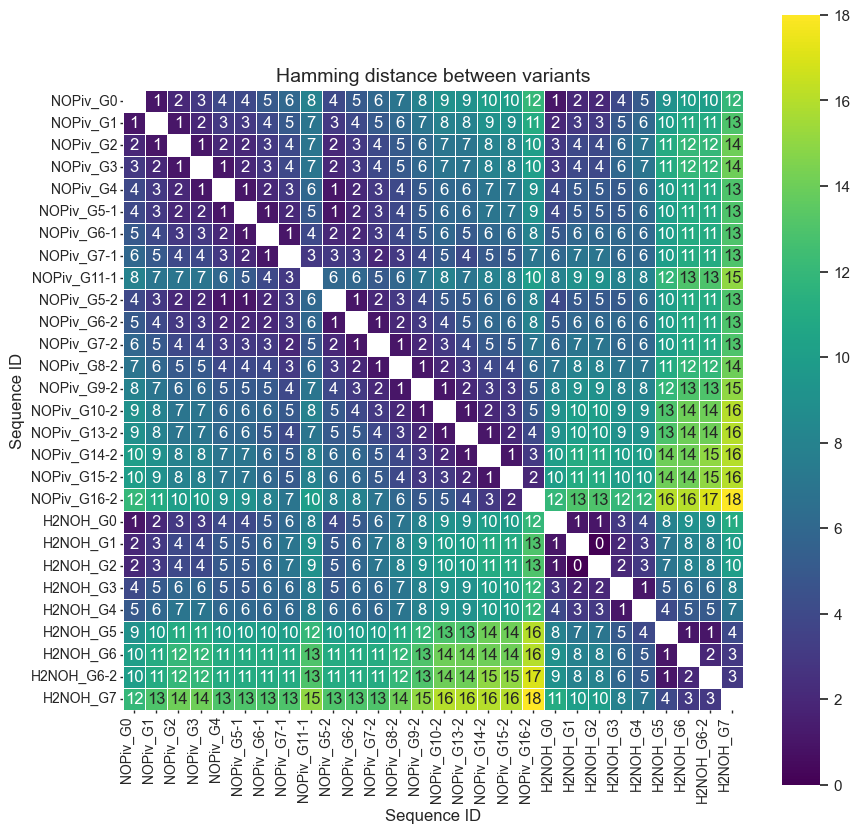

In [60]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_df, annot=True, fmt=".0f", cmap="viridis", cbar=True, square=True, ax=ax1,
            linewidths=0.5, linecolor="white")
ax1.set_title(f"Hamming distance between variants", fontsize=14)
ax1.set_xlabel("Sequence ID")
ax1.set_ylabel("Sequence ID")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax1 = clean_plt(ax1)
plt.savefig(f'{fig_dir}heatmap_levenshtein_lineage.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{fig_dir}heatmap_levenshtein_lineage.svg')

# Look at the sequence function data and make heatmaps across the landscape

In [39]:
nn_df = pd.read_csv(f'{output_dir}LevSeq_CombinedDF_pdt_filtered.csv')
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,Area parent mean,Area parent SD,# substitutions
0,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-1.818897,0.899269,479284.402650,26542.882998,1
1,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-13.151014,0.271694,479284.402650,26542.882998,1
2,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-14.600461,0.191423,479284.402650,26542.882998,1
3,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,W62S,A10,0.964103,39.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,8.0,D4F-A10,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,100422.7253,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-14.273569,0.209526,479284.402650,26542.882998,1
4,1,G12-2-M86C-W62X,T184G_G185T_A256T_T257G_G258T,W62V,A11,0.937931,29.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,9.0,D4F-A11,...,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,80172.7978,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-15.036483,0.167276,479284.402650,26542.882998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,40,ep-P8,C5T,T2I,G4,0.846154,78.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,77.0,D6B-G4,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,331518.9205,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.085983,0.756616,438160.254575,51122.815929,1
3599,40,ep-P8,C488T,S163L,G5,0.960000,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,78.0,D6B-G5,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,291902.5909,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.860908,0.666201,438160.254575,51122.815929,1
3600,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87.0,D6B-H2,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-6.591840,0.230890,438160.254575,51122.815929,2
3601,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93.0,D6B-H8,...,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677,438160.254575,51122.815929,2


# Plot various heatmaps

In [40]:
nopiv1_camp = ['NOPiv_G7-1']
nopiv2_camp = ['NOPiv_G13-2', 'NOPiv_G9-2', 'NOPiv_G10-2']
h2noh_camp  = ['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

def get_colour(value):
    if value == 0:
        return 0 #'white'
    if value < 0.8:
        return 1 #'blue'
    if value < 1.2:
        return 2 #'blue'
    else:
        return 3 #'red'
        
def make_heatmap_cat(df, label, remove_empty=False, figsize=(18, 4), column='Area plate standard norm', variants_to_highlight=None):
    # Now we want the actual number of positions we can do this by computing all numbers
    positions = []
    position_dict = defaultdict(list)
    position_to_value = defaultdict(dict)
    for subs, value in df[['amino_acid_substitutions', column]].values:
        for pos in subs.split('_'):
            # Only keep those that weren't retained
            positions.append(int(pos[1:-1]))
            position_dict[int(pos[1:-1])].append(pos[-1])
            if position_to_value[int(pos[1:-1])].get(pos[-1]):
                value = value
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
            else:
                position_to_value[int(pos[1:-1])][pos[-1]] = []
                value = value
                position_to_value[int(pos[1:-1])][pos[-1]].append(value)
    position_to_max_value = defaultdict(dict)
    for position, aas in position_to_value.items():
        for aa in aas:
            values = position_to_value.get(position).get(aa)
            position_to_max_value[position][aa] = float(np.nanmax(values))

    # Create an empty DataFrame for all letters and numbers
    letters = list("RHKDESTNQCGPAVILMFYW*")
    if remove_empty:
        numbers = list(position_dict.keys())
        numbers.sort()
    else:
        numbers = list(range(0, 204))  # 0 to 100
    
    # Initialize a DataFrame with zeros
    data = pd.DataFrame(0.0, index=letters, columns=numbers)
    
    highlight_cells = [] 

    # Fill the DataFrame with counts
    x = 0
    for number, letters_list in position_to_value.items():
        y = 0
        counts = Counter(letters_list)
        for letter, count in counts.items():
            data.at[letter, number] = get_colour(float(np.nanmax(count)))#float(np.nanmax(count)) #np.log(count)
            if variants_to_highlight:
                variant_str = f'{number}{letter}'
            y += 1
        x += 1
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data = data.fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, cmap=['white', '#0382BF', 'lightgrey', '#C04F15'], linewidths=.25)

    plt.xlabel("Residue position")
    plt.ylabel("Aminoacid substitution")
    plt.title(f"Positions explored across {label}")
    ax.set_yticks([y + 0.5 for y in range(data.shape[0])])
    ax.set_yticklabels(data.index, rotation=0)  # adjust rotation as needed
    if not remove_empty:
        xticks = range(0, data.shape[1], 5)
        ax.set_xticks([x + 0.5 for x in xticks])
        ax.set_xticklabels(data.columns[xticks], rotation=90)  # Adjust rotation for readability
    else:
        ax.set_xticks([x + 0.5 for x in range(data.shape[1])])
        ax.set_xticklabels(data.columns, rotation=90)  # adjust rotation as needed
    plt.tight_layout()
    plt.savefig(f'{fig_dir}heatmap_{label}_positions_area_norm.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{fig_dir}heatmap_{label}_positions_area_norm.svg')

    plt.show()

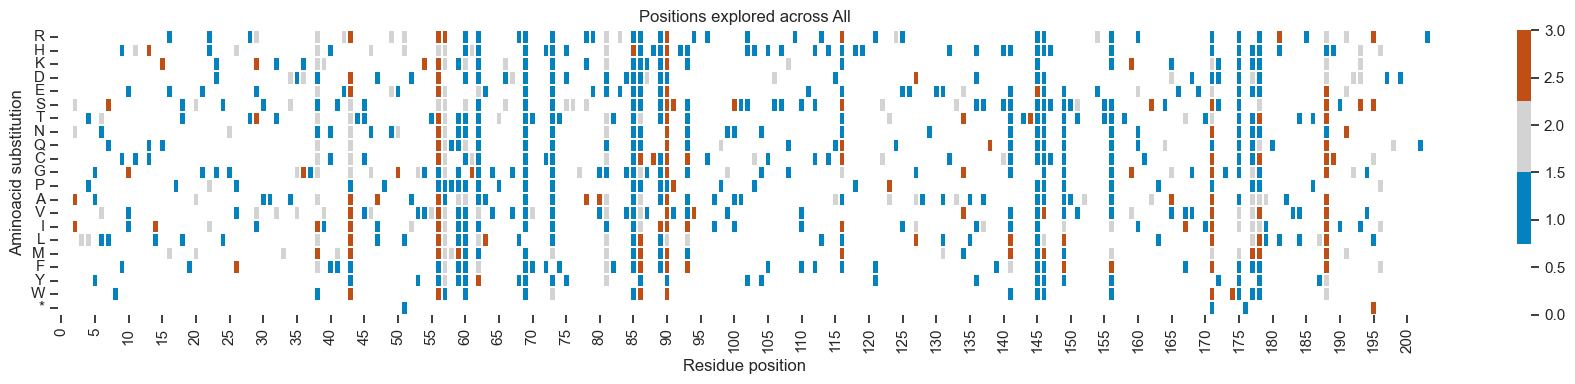

In [41]:
make_heatmap_cat(nn_df, 'All', column='Area fold change') # Everything


# Next look at the combinations of mutations in the H2NOH campaign

We want to investigate the possible "missed" oppurtunities. 

- What we can do is look at which mutations conferred good activity and then see if they have occured with any others

- Note for visualizations we remove any positions which have already been "finalized"

In [42]:
h2noh_df = nn_df[nn_df['campaign_name'].isin(h2noh_camp)]
h2noh_df['amino_acid_substitutions'].value_counts()
vals = []
for h_c in h2noh_camp:
    current_h_df = h2noh_df[h2noh_df['campaign_name'] == h_c]
    current_h_df = current_h_df[['aa_sequence', 'Area fold change']]
    current_h_df = current_h_df.groupby(['aa_sequence'])['Area fold change'].mean().reset_index()
    current_h_pos_df = current_h_df[current_h_df['Area fold change'] >= 1.4]
    print(h_c, len(set(current_h_df['aa_sequence'].values)), len(set(current_h_pos_df['aa_sequence'].values)), len(set(current_h_pos_df['aa_sequence'].values))/len(set(current_h_df['aa_sequence'].values)))
    vals.append(len(set(current_h_pos_df['aa_sequence'].values))/len(set(current_h_df['aa_sequence'].values)))

H2NOH_G6-2 170 2 0.011764705882352941
H2NOH_G5 286 8 0.027972027972027972
H2NOH_G6 98 10 0.10204081632653061
H2NOH_G2 207 36 0.17391304347826086
H2NOH_G3 96 1 0.010416666666666666
H2NOH_G4 91 0 0.0


In [43]:
ep = [0.028368794326241134, 0.028368794326241134]
ssm = [0.10204081632653061, 0.011764705882352941, 0.0]

In [44]:
np.mean(vals), np.mean(ep), np.mean(ssm)

(np.float64(0.054351210054306515),
 np.float64(0.028368794326241134),
 np.float64(0.037935174069627854))

In [45]:
# Filter to only h2noh
positive_df = nn_df[nn_df['Area fold change'] > 1.5]
positive_df = positive_df[positive_df['campaign_name'].isin(h2noh_camp)]

In [46]:
positive_df['aa_sequence'].value_counts()

aa_sequence
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAADVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTAPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSVVLQVAIWSHPYTKENDWLEHHHHHH     57
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAADVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTVPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSVVLQVAIWSHPYTKENDWLEHHHHHH     15
MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAADVLKDQVDEILDLMGRWVASNEHLIYYFSNPDTGEPIKEYFERVRARWGAWVLDTTCRDYNREWLDYQYERGLRHHRSKKGVTDGVRTAPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDVEGMYNALLKSVVLQVAIWSHPYTKENDWLEHHHHHH*    13
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAADVLKDQVDEILDLAGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTAPNTPLRYLIAGIYPLTATIKPLLAEKGGSPEDIEGMYNAWLKSVVLQVAIWSHPYTKENDWLEHHHHHH     12
MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAADVLKDQVDEILDLMGGWVASNEHLIYYFSNPDTGEPIKEYLERVRARWGAWVLDTTCRDYNREWLDYQYEVGLRHHRSKKGVTDGVRTAPNTPLRYLIA

In [47]:
positive_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L                    57
A134V_I149L              15
V116R                    13
V38I_I149L               12
A59M_I149L               10
                         ..
V116R_P188A               1
I149L_Y189C               1
V38I_A91P_I149L           1
V38I_A91P_A134V_I149L     1
A134T                     1
Name: count, Length: 82, dtype: int64

In [48]:
positive_df['# substitutions'] = [len(pos.split('_')) for pos in positive_df['amino_acid_substitutions'].values]

In [49]:
positive_potential_positions = []
duplicates = []
for aa in set(positive_df['amino_acid_substitutions'].values):
    for p in aa.split('_'):
        positive_potential_positions.append(int(p[1:-1]))
len(set(positive_potential_positions))

40

In [17]:
mutli_subs = positive_df[positive_df['# substitutions'] > 1]
len(mutli_subs['amino_acid_substitutions'].value_counts())

41

In [18]:
positive_potential_positions = []
duplicates = []
for aa in set(mutli_subs['amino_acid_substitutions'].values):
    for p in aa.split('_'):
        if int(p[1:-1]) in positive_potential_positions:
            duplicates.append(int(p[1:-1]))
        positive_potential_positions.append(int(p[1:-1]))
len(set(positive_potential_positions))

40

In [19]:
set(positive_potential_positions)

{2,
 7,
 10,
 13,
 14,
 26,
 29,
 38,
 43,
 56,
 59,
 61,
 62,
 63,
 78,
 80,
 86,
 88,
 89,
 90,
 91,
 93,
 94,
 100,
 116,
 123,
 127,
 134,
 141,
 145,
 149,
 156,
 159,
 167,
 174,
 181,
 188,
 189,
 191,
 195}

In [20]:
len(set(duplicates))

15

In [21]:
set(duplicates)

{10, 29, 38, 43, 59, 62, 89, 91, 100, 116, 134, 149, 159, 191, 195}

In [22]:
mutli_subs.to_csv('output/positive_multi_substitutions_h2noh.csv')

# Visualize these potentially epistatic sites

Here we want to visualize these potentially epistatic sites to see if as combinations they performed better than in isolation.



In [23]:
final_variant = lineage_df[lineage_df['name'] == 'H2NOH_G7']['AA'].values[0]

In [24]:
mutli_subs_dedup = mutli_subs.drop_duplicates(subset=['aa_sequence'])
mutli_subs_dedup['name'] = [f'{campaign_name.replace("_", "-")}_{v}' for campaign_name, v in mutli_subs_dedup[['campaign_name', 'amino_acid_substitutions']].values]
h2noh_substitutions_full = get_hamming(lineage_df, 'H2NOH_G0', 'H2NOH_G7')

# Step 1: Write initial FASTA
fasta_path = f'{output_dir}h2noh_multisubs_raw.fa'
with open(fasta_path, 'w') as fout:
    fout.write(f'>H2NOH-G7_{"_".join(h2noh_substitutions_full)}\n{final_variant}\n')
    for name, aa_seq in mutli_subs_dedup[['name', 'aa_sequence']].values:
        # if len(name.split('_')) > 5:
        #     name = '_'.join(name.split('_')[:4]) + '...'
        aa_seq = aa_seq.replace('*', '')
        fout.write(f'>{name}\n{aa_seq}\n')


--------------------------------------------------------------------------------
Hamming distance between H2NOH_G0 and H2NOH_G7	11	T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L	
--------------------------------------------------------------------------------


/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_3798/3224777426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutli_subs_dedup['name'] = [f'{campaign_name.replace("_", "-")}_{v}' for campaign_name, v in mutli_subs_dedup[['campaign_name', 'amino_acid_substitutions']].values]


# Visualize the joint and indiviudal substitutions across the plate

- Here we want to visualize a scatter plot across the dataset so that we can see what mutations co-occur with others.

In [25]:
h2noh_camp

['H2NOH_G6-2', 'H2NOH_G5', 'H2NOH_G6', 'H2NOH_G2', 'H2NOH_G3', 'H2NOH_G4']

In [26]:
df = positive_df[positive_df['campaign_name'].isin(h2noh_camp)]
rows = []
for pos, value in df[['amino_acid_substitutions', 'Area fold change']].values:
    positions = pos.split('_')
    if len(positions) < 6: # Remove large step libraries we aren't interested in these ones
        for i in positions:
            rows.append([pos, int(i[1:-1]), i[-1], float(value), len(pos.split('_'))])
vis_df = pd.DataFrame(rows, columns=['amino_acid_substitutions', 'position', 'aa', 'value', '# substiutions'])
vis_df = vis_df.sort_values(by='position')

In [27]:
h2noh_positions = [int(x[:-1]) for x in h2noh_substitutions]

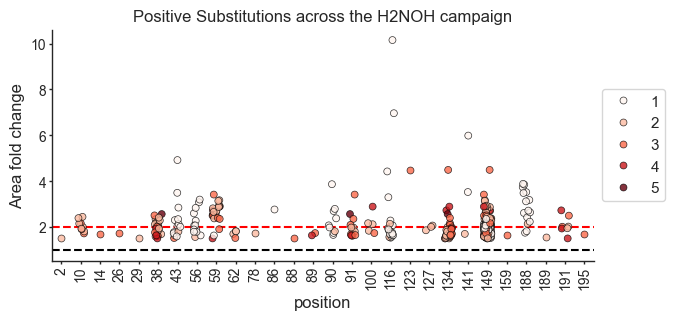

In [28]:
positive_positions = set(vis_df['position'].values)
vis_df['position'] = [str(int(p)) for p in vis_df['position'].values]
plt.figure(figsize=(7, 3))
sns.set(style="ticks")
ax = sns.stripplot(vis_df, x='position', y='value', hue='# substiutions', jitter=0.2, alpha=0.8, palette='Reds', linewidth=0.5, edgecolor="black")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--')

plt.ylabel('Area fold change')
plt.title('Positive Substitutions across the H2NOH campaign')
clean_plt(ax)
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{fig_dir}stripplot_Positive Substitutions across the H2NOH campaign - subs'.replace(' ', '_') + '.svg', dpi=300, bbox_inches='tight')

In [29]:
len(vis_df['position'].value_counts())

28

In [30]:
positive_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L                    57
A134V_I149L              15
V116R                    13
V38I_I149L               12
A59M_I149L               10
                         ..
V116R_P188A               1
I149L_Y189C               1
V38I_A91P_I149L           1
V38I_A91P_A134V_I149L     1
A134T                     1
Name: count, Length: 82, dtype: int64

In [31]:
positions_w_positive = [10, 38, 43, 56, 59, 90, 91, 100, 116, 127, 134, 149, 188, 191]
# Final variant: T2A_K29T_A59M_G61R_W62Y_L86F_V116R_V134A_I149L_I167V_W174L
tested_didnt_validate = [56, 90, 188]
to_test = [10, 38, 43, 89, 91, 100, 191, 127]
ommited_as_only_one_instance = [86]

# Manually go through the data to select interesting positions

Looked at file: output/positive_multi_substitutions_h2noh.csv